In [1]:
import torch
from pathlib import Path
import os
import hydra
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import sklearn.linear_model

os.chdir('/workspace')
import src

In [2]:
ds = 'ASCADf'
snr = [4, 5]

poi = {
    'ASCADf': {
        'snr4': 517,
        'snr5': 156
    },
    'ASCADv': {
        'snr4': 1071,
        'snr5': 188
    }
}

In [3]:
def calc_coeff(ds, snr, poi):
    p = poi[ds][f'snr{snr}']
    with hydra.initialize(config_path="../../conf", version_base='1.1'):
        cfg = hydra.compose(
            config_name='config',
            overrides=[
                "model=KAN1h",
                "model.train_params.steps=5000",
                f"dataset@train={ds}_profiling",
                f"dataset@test={ds}_attack",
                "trace_transforms=set_poi",
                f"trace_transforms.transforms.0.pois=[[{p}, {p+1}, 1]]",
                "trace_transforms.output_size=1",
                "label_transforms=multilabel_snr",
                f"label_transforms.target_snr={snr}",
                f"save_path=/workspace/results/ascad/regression/{ds}/{p}",
                "n_attack_traces=2000"
                ]
            )
    cfg.device = OmegaConf.create({'_target_': 'torch.device', 'device': 'cpu'})
    device = hydra.utils.instantiate(cfg.device)

    profiling_dataset = hydra.utils.instantiate(cfg.train.dataset)
    test_dataset = hydra.utils.instantiate(cfg.test.dataset)

    train_dataloader = torch.utils.data.DataLoader(
        profiling_dataset, batch_size=cfg.train.batch_size, shuffle=True
    )
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=cfg.test.batch_size, shuffle=False
    )
    KANds = src.utils.to_KAN_dataset(
        train_dataloader, test_dataloader,
        device=device)

    # Swap trace and label
    tmp = KANds['train_input']
    KANds['train_input'] = KANds['train_label']
    KANds['train_label'] = tmp
    tmp = KANds['test_input']
    KANds['test_input'] = KANds['test_label']
    KANds['test_label'] = tmp

    model = sklearn.linear_model.LinearRegression().fit(KANds['train_input'].numpy(), KANds['train_label'].numpy())
    score = model.score(KANds['train_input'].numpy(), KANds['train_label'].numpy())
    coef, intercept = model.coef_, model.intercept_
    return score, coef, intercept

In [4]:
score = []
coef = []
intercept = []
for s in snr:
    s, c, i = calc_coeff(ds, s, poi)
    score.append(s)
    coef.append(c)
    intercept.append(i)

In [5]:
np.abs(coef[0])+np.abs(coef[1])

array([[1.7919734 , 1.2855723 , 0.97722447, 0.8909272 , 1.4497954 ,
        0.6249528 , 0.5523508 , 0.7360131 ]], dtype=float32)

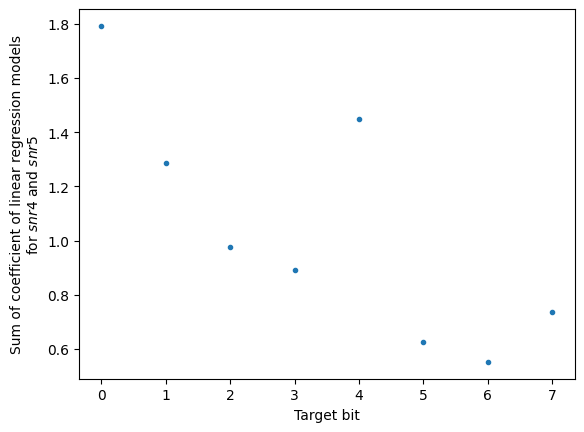

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((np.abs(coef[0])+np.abs(coef[1])).reshape(-1), '.')
ax.set_xlabel('Target bit')
ax.set_ylabel('Sum of coefficient of linear regression models\nfor $snr4$ and $snr5$')
plt.plot()
Path(f'/workspace/results/ascad/regression/{ds}').mkdir(exist_ok=True, parents=True)
fig.savefig(f'/workspace/results/ascad/regression/{ds}/coeffs.png', dpi=300, bbox_inches='tight')